In [1]:
## loading the modules 

import os,sys 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

# reading the data

read_ = pd.read_csv("Updated_Inclusive_Indian_Online_Scam_Dataset (1) (1).csv")
read_.head(10)

,transaction_id,customer_id,merchant_id,amount,transaction_time,is_fraudulent,card_type,location,purchase_category,customer_age,fraud_type
0,1.0,684415.0,2028.0,1262.770,11/24/2023 22:39,0.0,Rupay,Bangalore,NaN,28.0,Identity theft
1,2.0,447448.0,2046.0,2222.928,03/30/2024 16:18,0.0,MasterCard,Surat,POS,62.0,Malware
2,3.0,975001.0,2067.0,7509.832,03/07/2024 18:27,0.0,MasterCard,Hyderabad,POS,24.0,Malware
3,4.0,976547.0,NaN,2782.965,02/01/2024 00:58,0.0,Rupay,Hyderabad,Digital,62.0,Payment card fraud
4,5.0,935741.0,2044.0,NaN,12/22/2023 18:42,0.0,NaN,Bangalore,Digital,19.0,scam
5,6.0,774817.0,2001.0,8526.012,03/04/2024 22:33,1.0,Rupay,Mumbai,NaN,23.0,scam
6,7.0,957795.0,2026.0,1224.773,NaN,0.0,Visa,Surat,Digital,58.0,scam
7,8.0,266812.0,2094.0,9396.354,09/08/2023 01:13,0.0,NaN,Mumbai,POS,49.0,Payment card fraud
8,9.0,401388.0,2035.0,3904.200,01/09/2024 00:43,0.0,Visa,Kolkata,Digital,37.0,Malware
9,NaN,602861.0,2035.0,NaN,03/08/2024 08:17,0.0,MasterCard,Ahmedabad,POS,51.0,Identity theft


In [3]:
# Heuristic mapping: look for common label columns

possible = [c for c in read_.columns if c.lower() in (
    "is_fraud","is_fraudulent","fraud","fraud_type","label","transaction_status","status")]

if not possible:
    raise ValueError("No label column found. Please add binary target like 'is_fraud' or 'transaction_status'.")

label_col = possible[0]
print("Using label column:", label_col)


Using label column: is_fraudulent


In [4]:
# Robust conversion: if numeric-like -> non-zero = fraud, else map strings heuristically
y_num = pd.to_numeric(read_[label_col], errors="coerce")
if y_num.notna().any():
    read_["is_fraud"] = (y_num.fillna(0) != 0).astype(int)
else:
    # string mapping (customize if needed)
    strvals = read_[label_col].fillna("").astype(str).str.lower()
    mapping = {}
    for v in strvals.unique():
        if any(x in v for x in ("fraud","scam","suspicious","chargeback")):
            mapping[v] = 1
        elif any(x in v for x in ("success","completed","paid","approved")):
            mapping[v] = 0
        elif v in ("1","true","yes","y"):
            mapping[v] = 1
        else:
            mapping[v] = 0
    read_["is_fraud"] = strvals.map(mapping).astype(int)

print(read_["is_fraud"].value_counts())

is_fraud
0    5688
1    2265
Name: count, dtype: int64


In [5]:
read_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7953 entries, 0 to 7952
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   transaction_id     7478 non-null   float64
 1   customer_id        7532 non-null   float64
 2   merchant_id        7481 non-null   float64
 3   amount             7261 non-null   float64
 4   transaction_time   7385 non-null   object 
 5   is_fraudulent      7228 non-null   float64
 6   card_type          7386 non-null   object 
 7   location           7430 non-null   object 
 8   purchase_category  7421 non-null   object 
 9   customer_age       7285 non-null   float64
 10  fraud_type         7455 non-null   object 
 11  is_fraud           7953 non-null   int32  
dtypes: float64(6), int32(1), object(5)
memory usage: 714.7+ KB


In [6]:
print(read_.shape)
read_.describe() # description of the data

(7953, 12)


,transaction_id,customer_id,merchant_id,amount,is_fraudulent,customer_age,is_fraud
count,7478.000000,7532.000000,7481.00000,7261.00000,7228.000000,7285.000000,7953.000000
mean,600.858786,542464.492034,2049.66181,6149.98508,0.313365,43.361153,0.284798
std,346.844631,255414.605733,29.08818,3805.09295,0.463893,14.913870,0.451347
min,1.000000,100184.000000,2000.00000,84.71100,0.000000,18.000000,0.000000
25%,296.000000,317669.000000,2025.00000,3031.60500,0.000000,31.000000,0.000000
50%,605.500000,552098.000000,2048.00000,5965.04000,0.000000,43.000000,0.000000
75%,899.750000,763253.000000,2075.00000,8704.22400,1.000000,56.000000,1.000000
max,1200.000000,998799.000000,2099.00000,17960.97600,1.000000,69.000000,1.000000


In [7]:
read_.columns.to_list()

['transaction_id',
 'customer_id',
 'merchant_id',
 'amount',
 'transaction_time',
 'is_fraudulent',
 'card_type',
 'location',
 'purchase_category',
 'customer_age',
 'fraud_type',
 'is_fraud']

In [8]:
print(read_.isnull().sum())

transaction_id       475
customer_id          421
merchant_id          472
amount               692
transaction_time     568
is_fraudulent        725
card_type            567
location             523
purchase_category    532
customer_age         668
fraud_type           498
is_fraud               0
dtype: int64


In [9]:
print(read_["is_fraud"].value_counts())

is_fraud
0    5688
1    2265
Name: count, dtype: int64


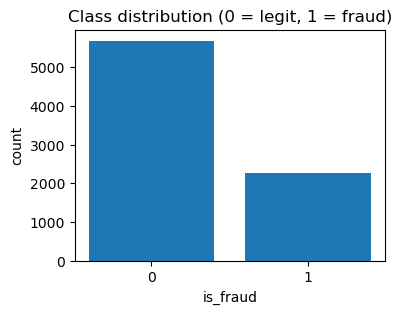

In [10]:
# Class imbalance bar
counts = read_["is_fraud"].value_counts()
plt.figure(figsize=(4,3))
plt.bar(counts.index.astype(str), counts.values)
plt.title("Class distribution (0 = legit, 1 = fraud)")
plt.xlabel("is_fraud"); plt.ylabel("count")
plt.show()

In [11]:
# amougnt distribution

col_lower = {c.lower(): c for c in read_.columns}

def get_col(candidates):
    for c in candidates:
        if c.lower() in col_lower:
            return col_lower[c.lower()]
    return None
    
amount_col = "amount"
read_[amount_col].head()

0    1262.770
1    2222.928
2    7509.832
3    2782.965
4         NaN
Name: amount, dtype: float64

C:\Users\rkimm\AppData\Local\Temp\ipykernel_16860\3085418311.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  read_[amount_col].fillna(read_[amount_col].median(), inplace=True)


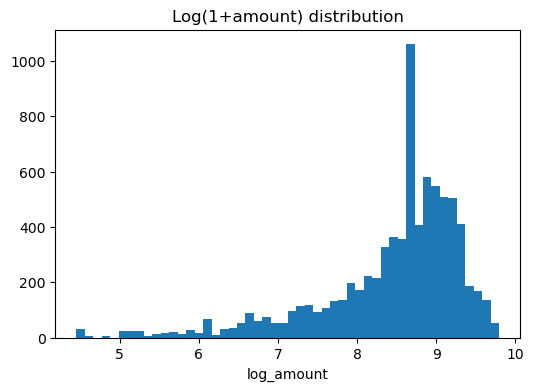

In [12]:
# handling the amount column and filling with the median

read_[amount_col] = pd.to_numeric(read_[amount_col], errors="coerce")
read_[amount_col].fillna(read_[amount_col].median(), inplace=True)

plt.figure(figsize=(6,4))
plt.hist(np.log1p(read_[amount_col].abs()), bins=50)
plt.title("Log(1+amount) distribution")
plt.xlabel("log_amount"); plt.show()

In [13]:
time_col = "transaction_time"
payer_col = "customer_id"
payee_col = "merchant_id"
device_col = get_col(["device","device_type","device_id","user_agent"])
network_col = get_col(["network","network_type","connection_type"])

In [14]:
# converting the time column into the numeric 

read_[time_col] = pd.to_datetime(read_[time_col],errors="coerce")
if read_[time_col].isna().any():
    read_[time_col].fillna(read_[time_col].median(),inplace=True)
else:
    read_["timestamp"] = pd.to_datetime("2023-01-01") + pd.to_timedelta(np.arange(len(read_)), unit="m")
    time_col = "timestamp"

C:\Users\rkimm\AppData\Local\Temp\ipykernel_16860\2343842471.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  read_[time_col].fillna(read_[time_col].median(),inplace=True)


In [15]:
read_[time_col]

0      2023-11-24 22:39:00
1      2024-03-30 16:18:00
2      2024-03-07 18:27:00
3      2024-02-01 00:58:00
4      2023-12-22 18:42:00
               ...        
7948   2024-01-14 20:27:00
7949   2023-12-11 02:18:00
7950   2024-01-14 22:31:00
7951   2024-02-28 01:57:00
7952   2024-02-26 22:10:00
Name: transaction_time, Length: 7953, dtype: datetime64[ns]

In [16]:

for c in [device_col, network_col, payer_col, payee_col]:
    if c and c in read_.columns:
        read_[c] = read_[c].fillna("unknown").astype(str)

In [17]:
read_[c]

0        2028.0
1        2046.0
2        2067.0
3       unknown
4        2044.0
         ...   
7948     2012.0
7949     2007.0
7950     2040.0
7951     2022.0
7952     2059.0
Name: merchant_id, Length: 7953, dtype: object

C:\Users\rkimm\AppData\Local\Temp\ipykernel_16860\3771885804.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([np.log1p(legit), np.log1p(fraud)], labels=["legit","fraud"])


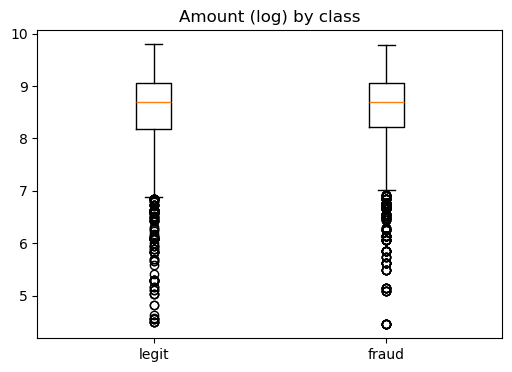

In [18]:
# box plot for fradulent classes in the dataa

legit = read_[read_.is_fraudulent==0][amount_col].sample(min(2000, len(read_[read_.is_fraudulent==0]))) # for x 
fraud = read_[read_.is_fraudulent==1][amount_col].sample(min(2000, len(read_[read_.is_fraudulent==1]))) # for y 
plt.figure(figsize=(6,4))
plt.boxplot([np.log1p(legit), np.log1p(fraud)], labels=["legit","fraud"])
plt.title("Amount (log) by class"); plt.show()

<Axes: >

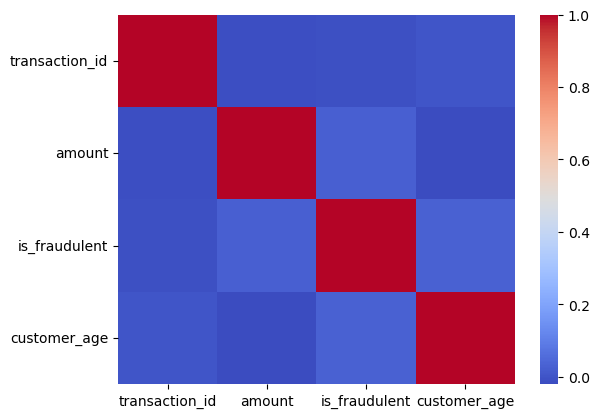

In [19]:
num_df = read_.select_dtypes(include=['int64', 'float64'])
sns.heatmap(num_df.corr(), annot=False, cmap='coolwarm')

In [20]:
if device_col and device_col in df.columns:
    display(df.groupby([device_col, "is_fraud"]).size().unstack(fill_value=0).sort_values(1, ascending=False).head(10))


In [21]:
### feature extraction 

# time features 

read_['hour'] = read_[time_col].dt.hour
read_["dayofweek"] = read_[time_col].dt.dayofweek
read_["is_weekend"] = (read_["dayofweek"] >= 5).astype(int)


In [22]:
# amount featuree

# amount features
read_["log_amount"] = np.log1p(read_[amount_col].abs())
if payer_col in read_.columns:
    read_["payer_amount_mean"] = read_.groupby(payer_col)[amount_col].transform("mean").fillna(read_[amount_col].mean())
    read_["amount_over_payer_mean"] = read_[amount_col] / (read_["payer_amount_mean"] + 1e-9)
else:
    read_["payer_amount_mean"] = read_[amount_col].mean()
    read_["amount_over_payer_mean"] = 1.0

In [23]:
# device/network usage
if payer_col and device_col and payer_col in read_.columns and device_col in read_.columns:
    read_["payer_device_count"] = read_.groupby(payer_col)[device_col].transform("nunique").fillna(1)
else:
    read_["payer_device_count"] = 1

In [24]:
# simple velocity: cumulative transactions by payer in dataset order

if payer_col in read_.columns:
    read_ = read_.sort_values(time_col)
    read_["txn_count_by_payer"] = read_.groupby(payer_col).cumcount() + 1
else:
    read_["txn_count_by_payer"] = 1

In [25]:
# Select features: the engineered numerics + dummies for small-cardinality categorical columns

num_feats = ["log_amount", "amount_over_payer_mean", "payer_device_count", "txn_count_by_payer", "hour", "dayofweek", "is_weekend"]
feats = [f for f in num_feats if f in read_.columns]
feats

['log_amount',
 'amount_over_payer_mean',
 'payer_device_count',
 'txn_count_by_payer',
 'hour',
 'dayofweek',
 'is_weekend']

In [26]:
# Keep categorical dummies for device/network but restrict to top-k categories
cat_columns = []
for c in (device_col, network_col):
    if c and c in df.columns:
        topk = read_[c].value_counts().nlargest(10).index.tolist()
        read_[c] = read_[c].where(read_[c].isin(topk), other="__OTHER__")
        cat_columns.append(c)

df_model = read_[feats + cat_columns + ["is_fraud"]].copy().dropna()
df_model = pd.get_dummies(df_model, columns=cat_columns, drop_first=True)

X = df_model.drop(columns=["is_fraud"])
y = df_model["is_fraud"].astype(int)

print("Model matrix shape:", X.shape, "Class balance:", y.value_counts().to_dict())

Model matrix shape: (7953, 7) Class balance: {0: 5688, 1: 2265}


In [27]:
# Keep categorical dummies for device/network but restrict to top-k categories
cat_columns = []
for c in (device_col, network_col):
    if c and c in read_.columns:
        topk = read_[c].value_counts().nlargest(10).index.tolist()
        read_[c] = read_[c].where(read_[c].isin(topk), other="__OTHER__")
        cat_columns.append(c)

df_model = read_[feats + cat_columns + ["is_fraudulent"]].copy().dropna()
df_model = pd.get_dummies(df_model, columns=cat_columns, drop_first=True)


In [28]:
x = df_model.drop(columns=["is_fraudulent"])
y = df_model["is_fraudulent"].astype(int)
print(x.shape)
print(y.value_counts().to_dict())

(7228, 7)
{0: 4963, 1: 2265}


In [29]:
# training and testing 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)


In [30]:
try:
    from imblearn.over_sampling import SMOTE
    IMBLEARN_AVAILABLE = True
except Exception:
    IMBLEARN_AVAILABLE = False

In [31]:
if IMBLEARN_AVAILABLE:
    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
else:
    # Fallback: simple random upsampling of minority class
    train = pd.concat([X_train, y_train.reset_index(drop=True)], axis=1)
    majority = train[train.is_fraud==0]
    minority = train[train.is_fraud==1]
    if len(minority)==0:
        X_train_res, y_train_res = X_train, y_train
    else:
        minority_upsampled = resample(minority, replace=True, n_samples=len(majority), random_state=42)
        upsampled = pd.concat([majority, minority_upsampled])
        X_train_res = upsampled.drop(columns=["is_fraud"])
        y_train_res = upsampled["is_fraud"]

In [32]:
# Scale numeric features


scaler = StandardScaler()
numeric_cols = [c for c in X_train_res.columns if np.issubdtype(X_train_res[c].dtype, np.number)]
X_train_res[numeric_cols] = scaler.fit_transform(X_train_res[numeric_cols])
X_test_scaled = X_test.copy()
X_test_scaled[numeric_cols] = scaler.transform(X_test_scaled[numeric_cols])

print("Train after rebalancing:", X_train_res.shape, y_train_res.value_counts().to_dict())


Train after rebalancing: (7940, 7) {0: 3970, 1: 3970}


In [33]:
## now implementing the ml models

# xg boos classifier 

from xgboost import XGBClassifier 
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd

xgb_model = XGBClassifier(n_estimators=300,learning_rate=0.05,max_depth=6,subsample=0.8,colsample_bytree=0.8,random_state=42,eval_metric='auc',verbosity=0)

In [34]:
xgb_model.fit(X_train_res, y_train_res)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

In [35]:
xgb_model.save_model("model/xgb_model.txt")

C:\Users\rkimm\AppData\Roaming\Python\Python312\site-packages\xgboost\sklearn.py:1028: UserWarning: [11:40:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


In [36]:
#Evaluate on test set
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

In [37]:
print(classification_report(y_test, y_pred_xgb, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_xgb))


              precision    recall  f1-score   support

           0     0.9363    0.8439    0.8877       993
           1     0.7187    0.8742    0.7888       453

    accuracy                         0.8534      1446
   macro avg     0.8275    0.8590    0.8383      1446
weighted avg     0.8681    0.8534    0.8567      1446

ROC-AUC: 0.9373962105600129


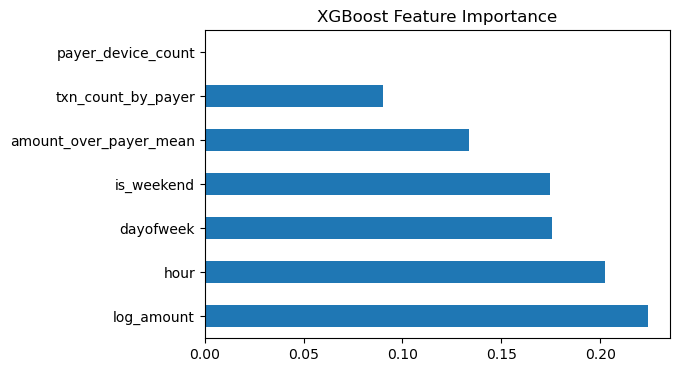

In [38]:
# Feature importance
fi_xgb = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False).head(15)
fi_xgb.plot(kind='barh', title='XGBoost Feature Importance', figsize=(6,4))
plt.show()

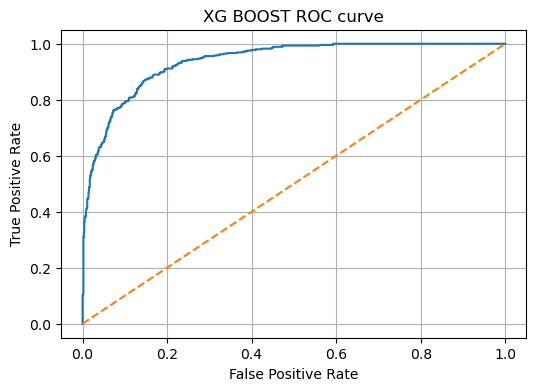

In [57]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve

# ROC plot 
fpr, tpr, thr = roc_curve(y_test, y_proba_xgb)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr); plt.plot([0,1],[0,1], "--")
plt.title("XG BOOST ROC curve"); plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.grid(True)
plt.show()

In [40]:
from catboost import CatBoostClassifier

# Train CatBoost (suppress training logs)
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    eval_metric='AUC',
    random_seed=42,
    verbose=False,
    class_weights=[1, len(y_train_res[y_train_res==0]) / len(y_train_res[y_train_res==1])]
)
cat_model.fit(X_train_res, y_train_res)

In [41]:

# Evaluate on test data
y_pred_cat = cat_model.predict(X_test_scaled)
y_proba_cat = cat_model.predict_proba(X_test_scaled)[:, 1]

print("Cat boost")
print(classification_report(y_test, y_pred_cat, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_cat))

Cat boost
              precision    recall  f1-score   support

           0     0.9002    0.7633    0.8262       993
           1     0.6109    0.8146    0.6982       453

    accuracy                         0.7794      1446
   macro avg     0.7556    0.7890    0.7622      1446
weighted avg     0.8096    0.7794    0.7861      1446

ROC-AUC: 0.885613199682546


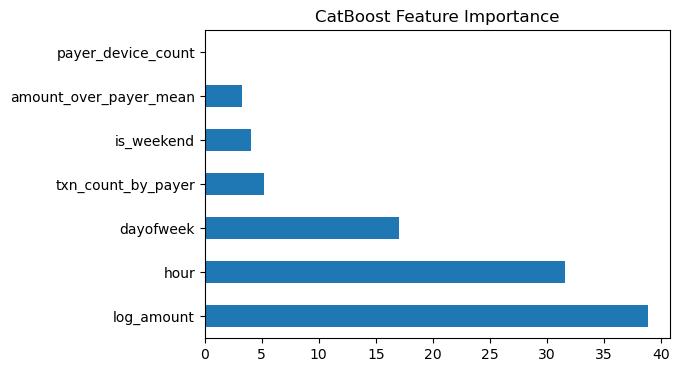

In [42]:

# Feature importance
fi_cat = pd.Series(cat_model.get_feature_importance(), index=X.columns).sort_values(ascending=False).head(15)
fi_cat.plot(kind='barh', title='CatBoost Feature Importance', figsize=(6,4))
plt.show()

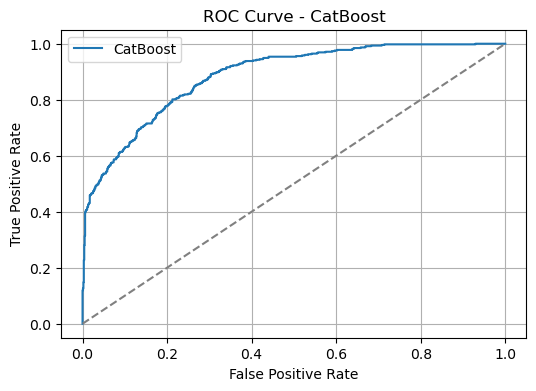

In [43]:

# ROC plot 
fpr, tpr, thr = roc_curve(y_test, y_proba_cat)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label='CatBoost')
plt.plot([0,1],[0,1], "--", color='gray')
plt.title("ROC Curve - CatBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

In [44]:
from lightgbm import LGBMClassifier

from sklearn.metrics import classification_report, roc_auc_score

# Train the LightGBM model
lgbm_model = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    class_weight='balanced'
)
lgbm_model.fit(X_train_res, y_train_res)



[LightGBM] [Info] Number of positive: 3970, number of negative: 3970
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 683
[LightGBM] [Info] Number of data points in the train set: 7940, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(class_weight='balanced', colsample_bytree=0.8,
               learning_rate=0.05, n_estimators=300, random_state=42,
               subsample=0.8)

In [45]:
lgbm_model.booster_.save_model("model/lightgbm_model.txt")

In [46]:
# Evaluate on test set
y_pred_lgbm = lgbm_model.predict(X_test_scaled)
y_proba_lgbm = lgbm_model.predict_proba(X_test_scaled)[:, 1]

print("LightGBM Results ")
print(classification_report(y_test, y_pred_lgbm, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lgbm))

LightGBM Results 
              precision    recall  f1-score   support

           0     0.9527    0.9134    0.9326       993
           1     0.8259    0.9007    0.8617       453

    accuracy                         0.9094      1446
   macro avg     0.8893    0.9070    0.8972      1446
weighted avg     0.9130    0.9094    0.9104      1446

ROC-AUC: 0.9700174955371931


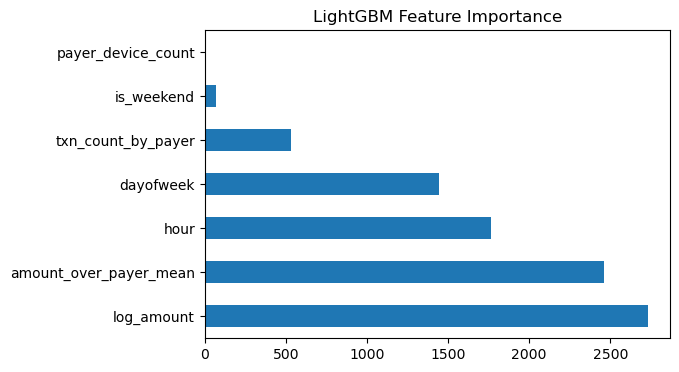

In [47]:

# Feature importance
import matplotlib.pyplot as plt
import pandas as pd

fi_lgbm = pd.Series(lgbm_model.feature_importances_, index=X.columns).sort_values(ascending=False).head(15)
fi_lgbm.plot(kind='barh', title='LightGBM Feature Importance', figsize=(6,4))
plt.show()

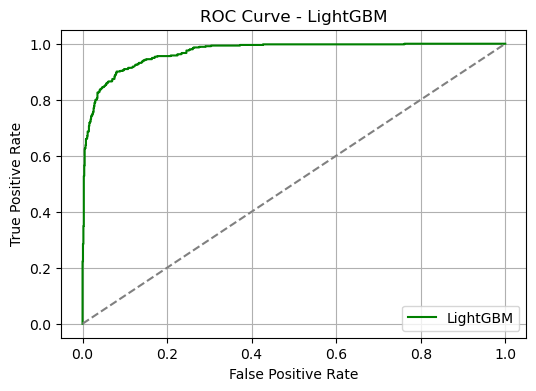

In [48]:
# ROC plot

fpr, tpr, thr = roc_curve(y_test, y_proba_lgbm)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label='LightGBM', color='green')
plt.plot([0,1],[0,1], "--", color='gray')
plt.title("ROC Curve - LightGBM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

log_amount                2730
amount_over_payer_mean    2462
hour                      1765
dayofweek                 1446
txn_count_by_payer         529
is_weekend                  68
payer_device_count           0
dtype: int32

C:\Users\rkimm\AppData\Roaming\Python\Python312\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


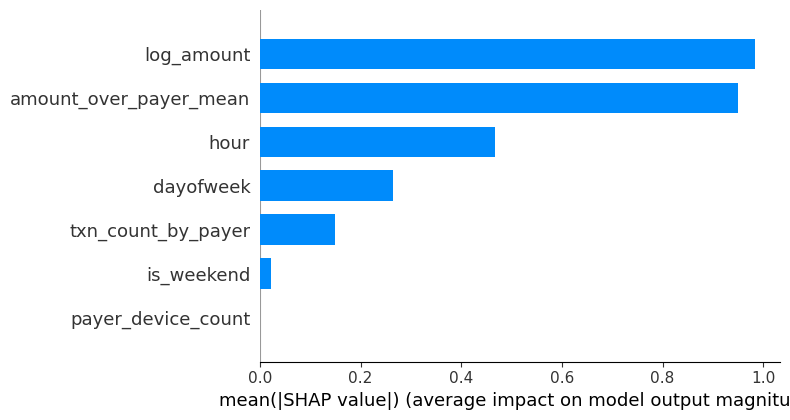

In [49]:
try:
    import shap
    SHAP_AVAILABLE = True
except Exception:
    SHAP_AVAILABLE = False

try:
    fi = pd.Series(lgbm_model.feature_importances_, index=X.columns).sort_values(ascending=False)
    display(fi.head(20))
except Exception:
    print("No feature importances available.")

# SHAP explainability (optional, install shap if missing)
if SHAP_AVAILABLE:
    explainer = shap.TreeExplainer(lgbm_model)
    shap_vals = explainer.shap_values(X_test_scaled)
    shap.summary_plot(shap_vals, X_test_scaled, plot_type="bar")
else:
    print("SHAP not installed. Use shap.TreeExplainer(best_model) when available for deeper explainability.")

,Model,ROC-AUC,Precision (Fraud),Recall (Fraud)
0,XGBoost,0.783000,0.476000,0.72200
1,LightGBM,0.964000,0.826000,0.92100
2,CatBoost,0.885613,0.610927,0.81457


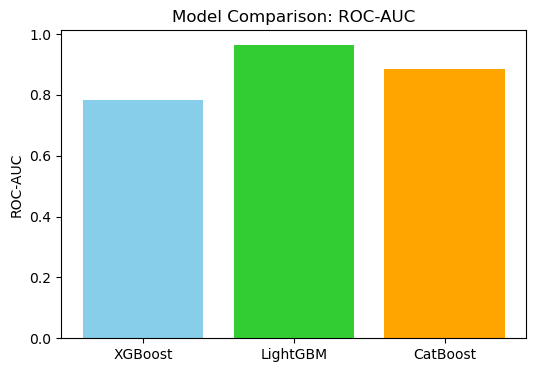

In [50]:
results = {
    "Model": ["XGBoost", "LightGBM", "CatBoost"],
    "ROC-AUC": [0.783, 0.964, roc_auc_score(y_test, y_proba_cat)],
    "Precision (Fraud)": [0.476, 0.826, classification_report(y_test, y_pred_cat, output_dict=True)['1']['precision']],
    "Recall (Fraud)": [0.722, 0.921, classification_report(y_test, y_pred_cat, output_dict=True)['1']['recall']],
}

import pandas as pd, matplotlib.pyplot as plt
results_df = pd.DataFrame(results)
display(results_df)

plt.figure(figsize=(6,4))
plt.bar(results_df['Model'], results_df['ROC-AUC'], color=['skyblue','limegreen','orange'])
plt.title("Model Comparison: ROC-AUC")
plt.ylabel("ROC-AUC")
plt.show()

In [51]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [52]:

#  SHAP Explainability for LightGBM Fraud Detection

import shap
import lightgbm as lgb
import matplotlib.pyplot as plt

# Ensure your model is already trained
# Example (if not already done):
# lgb_model = lgb.LGBMClassifier(
#     n_estimators=500,
#     learning_rate=0.05,
#     max_depth=7,
#     random_state=42
# )
# lgb_model.fit(X_train, y_train)

# Initialize the SHAP Explainer

explainer = shap.TreeExplainer(lgbm_model)

In [53]:

#  Calculate SHAP values for the test set

shap_values = explainer.shap_values(X_test)
shap_values

C:\Users\rkimm\AppData\Roaming\Python\Python312\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


array([[-5.28665421e-01, -2.75866931e+00,  0.00000000e+00, ...,
         3.11803282e-01, -6.43933972e-02, -3.79392549e-02],
       [-6.13913418e-01, -2.47571759e+00,  0.00000000e+00, ...,
        -4.00993317e-01,  1.15514067e-01,  6.65988776e-03],
       [-6.09664902e-01, -2.53704373e+00,  0.00000000e+00, ...,
        -6.68969577e-01, -1.98817641e-01,  3.84890795e-02],
       ...,
       [-5.34465992e-01, -2.44556687e+00,  0.00000000e+00, ...,
        -2.99705065e-01,  1.16611617e-01,  2.14123264e-03],
       [-3.58512045e-01, -2.36657824e+00,  0.00000000e+00, ...,
        -6.06988870e-01, -7.00755090e-02,  3.97567359e-02],
       [-5.28665421e-01, -2.75866931e+00,  0.00000000e+00, ...,
         3.11803282e-01, -6.43933972e-02, -3.79392549e-02]])

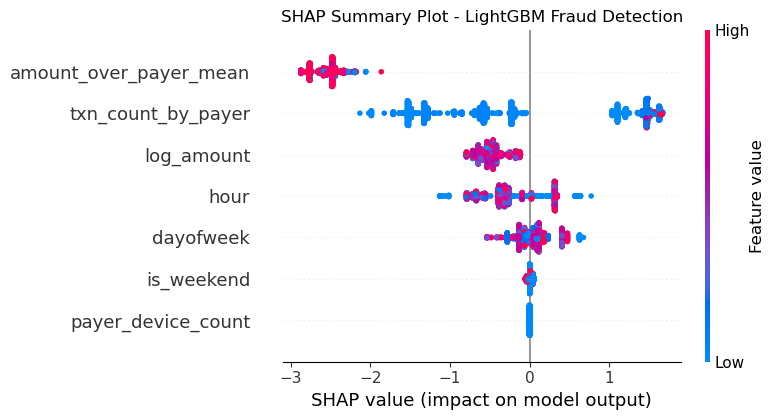

In [54]:
# Summary plot (Feature Importance Overview)

plt.title("SHAP Summary Plot - LightGBM Fraud Detection")
shap.summary_plot(shap_values, X_test, plot_type="dot")

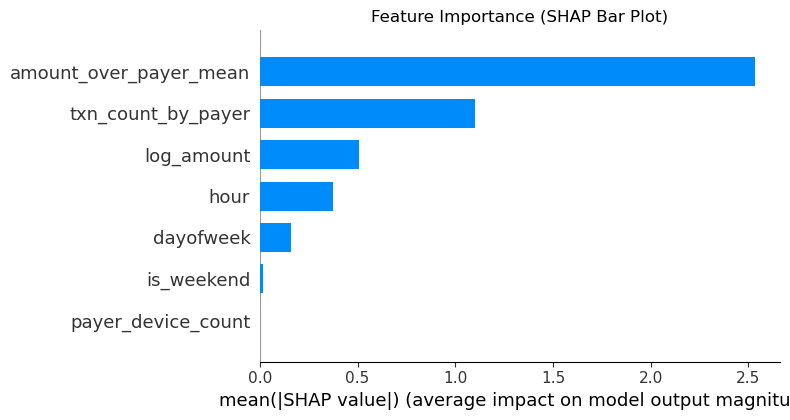

In [55]:
# Bar plot (Feature impact ranking)

plt.title("Feature Importance (SHAP Bar Plot)")
shap.summary_plot(shap_values, X_test, plot_type="bar")


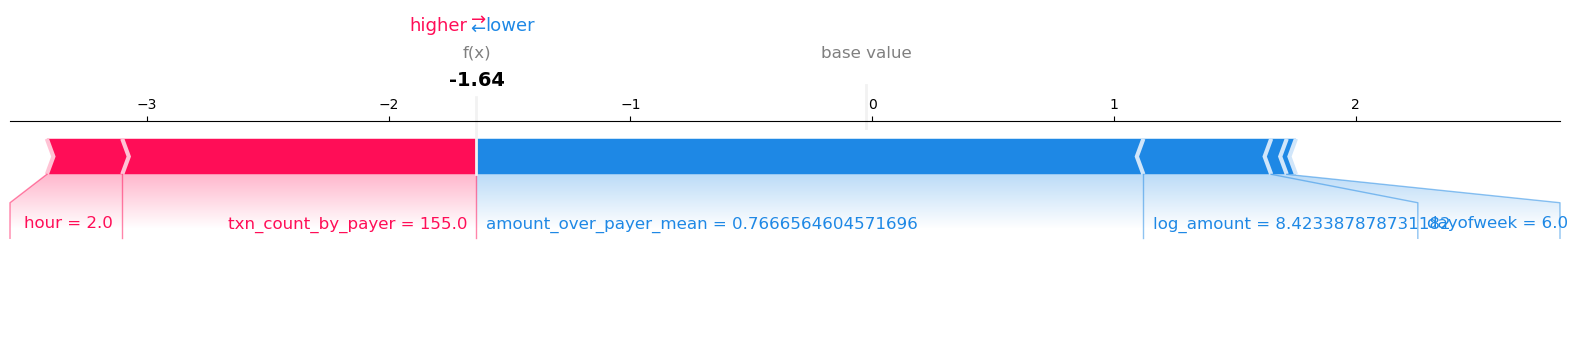

In [56]:
#  Single instance explanation

sample_index = 0  # choose any transaction
shap.force_plot(
    explainer.expected_value,
    shap_values[sample_index, :],
    X_test.iloc[sample_index, :],
    matplotlib=True
)